# Using Financial Statement Metrics to Predict the Stock Market

## Anh Nguyen (hzn3kf) , Connor Killion (cmk7xr), Thomas McIntyre (gem5cm)

#### The five main sections are labeled for data import and processing, data splitting, EDAs, model construction, and model evaluation. All cells are fully commented explaining what is being done. Some cells are commented out since they take a long amount of time to run and we stored the output beneath those cells. Some of the main 5 sections are combined and some have more than one part. Enjoy!

In [121]:
## In this cell we will call the packages used in the notebook and initiate our spark session ##

# Package Calls
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.ml import Pipeline  
from pyspark.ml.feature import *  
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import expr

# Spark Session
spark = SparkSession.builder \
        .master("local") \
        .appName("mllib_classifier") \
        .config("spark.driver.memory", "16g")\
        .getOrCreate()
sc = spark.sparkContext

# DATA PREPROCESSING AND DATA SPLITTING

## In Time DATA / Development Data

## Creating the Response Variable (did the stock increase or decrease in the year 2014)

In our project we would like to see if we are able to fit a model using common balance sheet and financial statement line items to accurately predict whether the stock price of the company went up or down. To do this, we will use 2014 data to train our model. It is understood that not all companies have the same fiscal year start and end date, however we will use the assumption for this analysis that the start of the 2014 fiscal year is January 1st, 2014 and the end of the fiscal year is December 31st, 2014. To create our response variable of whether the stock increases or decreased over that time period we will use the following logic: 

##### Stock Change = (Closing Price 2014-12-31) - (Closing Price 2013-12-31)

##### If Stock Change is positive then label == "1"

##### If Stock Change is negative then label == "0"

Thus, if our label is 1 that means the stock increased over this time period and if  the label is 0 then the stock decreased over this time period. This variable was created and sourced from columns in the prices-split-adjusted.csv and will be appended to our main dataset containing all of the balance sheet/financial statement items.

In [85]:
## In this cell we read in our dataset where we can create our response variable from ##

price_filename = "/project/ds5559/Team7_Spring22/Kaggle Data/prices-split-adjusted.csv"
psa_df = spark.read.csv(price_filename,  inferSchema=True, header = True)

## Here we filter our dataframe to be df13 to be the day of 2013-12-31
df13 = psa_df.filter((psa_df.date == "2013-12-31"))

## Here we filter our dataframe to be df13 to be the day of 2014-12-31
df14 = psa_df.select("date", "close", "symbol").filter((col("date") == "2014-12-31"))

## Here we renamed some columns to keep track of steps
df14 = df14.withColumnRenamed('close', 'close_end_of_2014')
df14 = df14.withColumnRenamed('date', 'date_2014')

## Here we joined df13 and df14 together and selected the variables we need to create the yearDelta
df1314= df13.join(df14, "symbol")
df1314 = df1314.select("symbol","close", "close_end_of_2014")
df1314 = df1314.withColumn("yearDelta", df1314.close_end_of_2014 - df1314.close)

## Here we create a user defined function to create our label variable from yearDelta
target_udf = udf(lambda x: 0 if x < 0 else 1, IntegerType()) # if negative = 0, else positve
df1314 = df1314.withColumn("label", target_udf(df1314.yearDelta))

## Finally, we select only the variables we need from this data set after our label is complete
response_variable_df = df1314.select("symbol", "yearDelta", "label")
response_variable_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  377|
|    0|  113|
+-----+-----+



## Appending the industry 

Alongside fitting a supervised model, we will potentially like to look into some industry analysis and look at which industries were most prosperous and struggling in 2014 fiscal year. This will allow for a deep dive into some of the financial statement line items that are deemed to be important from our supervised model. It will also be of potential interest to see how our final model performs industry by industry.

In [86]:
## In this cell we will append the industry column from another dataset to our response variable dataframe created above

ind_filename = "/project/ds5559/Team7_Spring22/Kaggle Data/securities.csv"
ind_df = spark.read.csv(ind_filename,  inferSchema=True, header = True).select("Ticker Symbol", "GICS Sector")
ind_df = ind_df.withColumnRenamed("Ticker Symbol", "symbol")

## We now have a dataset containing the industry as well as our response variable
ind_resp_df = response_variable_df.join(ind_df, "symbol")
ind_resp_df.show(5)

+------+------------------+-----+--------------------+
|symbol|         yearDelta|label|         GICS Sector|
+------+------------------+-----+--------------------+
|  ALXN| 52.14999399999999|    1|         Health Care|
|   GIS|3.4200020000000038|    1|    Consumer Staples|
|     K| 4.370002000000007|    1|    Consumer Staples|
|   LEN|              5.25|    1|Consumer Discreti...|
|  SPGI|         10.780006|    1|          Financials|
+------+------------------+-----+--------------------+
only showing top 5 rows



## Getting the 2014 year from fundamentals.csv

The following file (fundamentals.csv) contains the all of the features we will be using when attempting to predict whether a companies stock price increased or decreased in 2014. We will append the the balance sheet items to our label and industry variables for each ticker we have these features available for. For our final in time data set, we have information for 423 companies. Of the 423 companies, 333 companies had a green year when referring to stock price, while 90 companies had a red year. Our data is relatively unbalanced, however there is enough labels on both sides to hopefully get some performance lift in classifying positive movers versus negative movers.

In [87]:
## In this cell we join 70+ financial statement line items onto our dataset containing our industry, tickers, and response variable

fund_filename = "/project/ds5559/Team7_Spring22/Kaggle Data/fundamentals.csv"
fund_df = spark.read.csv(fund_filename,  inferSchema=True, header = True).filter(col("For Year") == 2014.0)
fund_df =fund_df.withColumnRenamed("Ticker Symbol", "symbol")

## Here we complete the join to create our training dataframe and show the counts and schema after all the joins
training_df = fund_df.join(ind_resp_df, "symbol")
training_df.groupby("label").count().show()
training_df.printSchema()

+-----+-----+
|label|count|
+-----+-----+
|    1|  333|
|    0|   90|
+-----+-----+

root
 |-- symbol: string (nullable = true)
 |-- _c0: integer (nullable = true)
 |-- Period Ending: string (nullable = true)
 |-- Accounts Payable: double (nullable = true)
 |-- Accounts Receivable: double (nullable = true)
 |-- Add'l income/expense items: double (nullable = true)
 |-- After Tax ROE: double (nullable = true)
 |-- Capital Expenditures: double (nullable = true)
 |-- Capital Surplus: double (nullable = true)
 |-- Cash Ratio: double (nullable = true)
 |-- Cash and Cash Equivalents: double (nullable = true)
 |-- Changes in Inventories: double (nullable = true)
 |-- Common Stocks: double (nullable = true)
 |-- Cost of Revenue: double (nullable = true)
 |-- Current Ratio: double (nullable = true)
 |-- Deferred Asset Charges: double (nullable = true)
 |-- Deferred Liability Charges: double (nullable = true)
 |-- Depreciation: double (nullable = true)
 |-- Earnings Before Interest and Tax: doubl

# End of in time data manipulation

# Out of time dataset/validation dataset creation.

The out of time dataset we decided to use will be for the year 2015. Once again we had to make an assumption that the fiscal years for all companies available was from January 1st, 2015 to December 31st, 2015. We constructed the response variable, pulled the industry variable, and extracted the balance sheet feature variables in the same manner as the in time data sample. For our out of time sample, we had 200 companies in the green versus 217 companies in the red when referring to stock price. The out of time data sample is slightly more balanced than the in time sample, which will be interesting to see if we are able to separate the positive and negative movers in our analysis.

In [88]:
## In this cell we combine all of the same previous data manipulations to create our out of time testing dataframe

## Response variable construction with updated time filters
price_filename = "/project/ds5559/Team7_Spring22/Kaggle Data/prices-split-adjusted.csv"
psa_df = spark.read.csv(price_filename,  inferSchema=True, header = True)
df13 = psa_df.filter((psa_df.date == "2014-12-31"))
df14 = psa_df.select("date", "close", "symbol").filter((col("date") == "2015-12-31"))
df14 = df14.withColumnRenamed('close', 'close_end_of_2014')
df14 = df14.withColumnRenamed('date', 'date_2014')
df1314= df13.join(df14, "symbol")
df1314 = df1314.select("symbol","close", "close_end_of_2014")
df1314 = df1314.withColumn("yearDelta", df1314.close_end_of_2014 - df1314.close)
target_udf = udf(lambda x: 0 if x < 0 else 1, IntegerType()) # if negative = 0, else positve
df1314 = df1314.withColumn("label", target_udf(df1314.yearDelta))
response_variable_df = df1314.select("symbol", "yearDelta", "label")
response_variable_df.groupby("label").count().show() 

## Joining the industry name onto the data
ind_filename = "/project/ds5559/Team7_Spring22/Kaggle Data/securities.csv"
ind_df = spark.read.csv(ind_filename,  inferSchema=True, header = True).select("Ticker Symbol", "GICS Sector")
ind_df = ind_df.withColumnRenamed("Ticker Symbol", "symbol")
ind_resp_df = response_variable_df.join(ind_df, "symbol")
ind_resp_df.show(5)

## Appending the financial statement line items to create our out of time testing dataframe
fund_filename = "/project/ds5559/Team7_Spring22/Kaggle Data/fundamentals.csv"
fund_df = spark.read.csv(fund_filename,  inferSchema=True, header = True).filter(col("For Year") == 2015.0)
fund_df =fund_df.withColumnRenamed("Ticker Symbol", "symbol")
testing_df = fund_df.join(ind_resp_df, "symbol")
testing_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|  225|
|    0|  265|
+-----+-----+

+------+-----------------+-----+--------------------+
|symbol|        yearDelta|label|         GICS Sector|
+------+-----------------+-----+--------------------+
|  ALXN|5.720000999999996|    1|         Health Care|
|   GIS|4.329997999999996|    1|    Consumer Staples|
|     K|6.829994999999997|    1|    Consumer Staples|
|   LEN|4.099998999999997|    1|Consumer Discreti...|
|  SPGI|9.599998999999997|    1|          Financials|
+------+-----------------+-----+--------------------+
only showing top 5 rows

+-----+-----+
|label|count|
+-----+-----+
|    1|  200|
|    0|  217|
+-----+-----+



# RESPONSE VARIABLE EDA

###### Lets take a look at how the prices moved by each industry in 2014. This will be used to understand our response variable more.

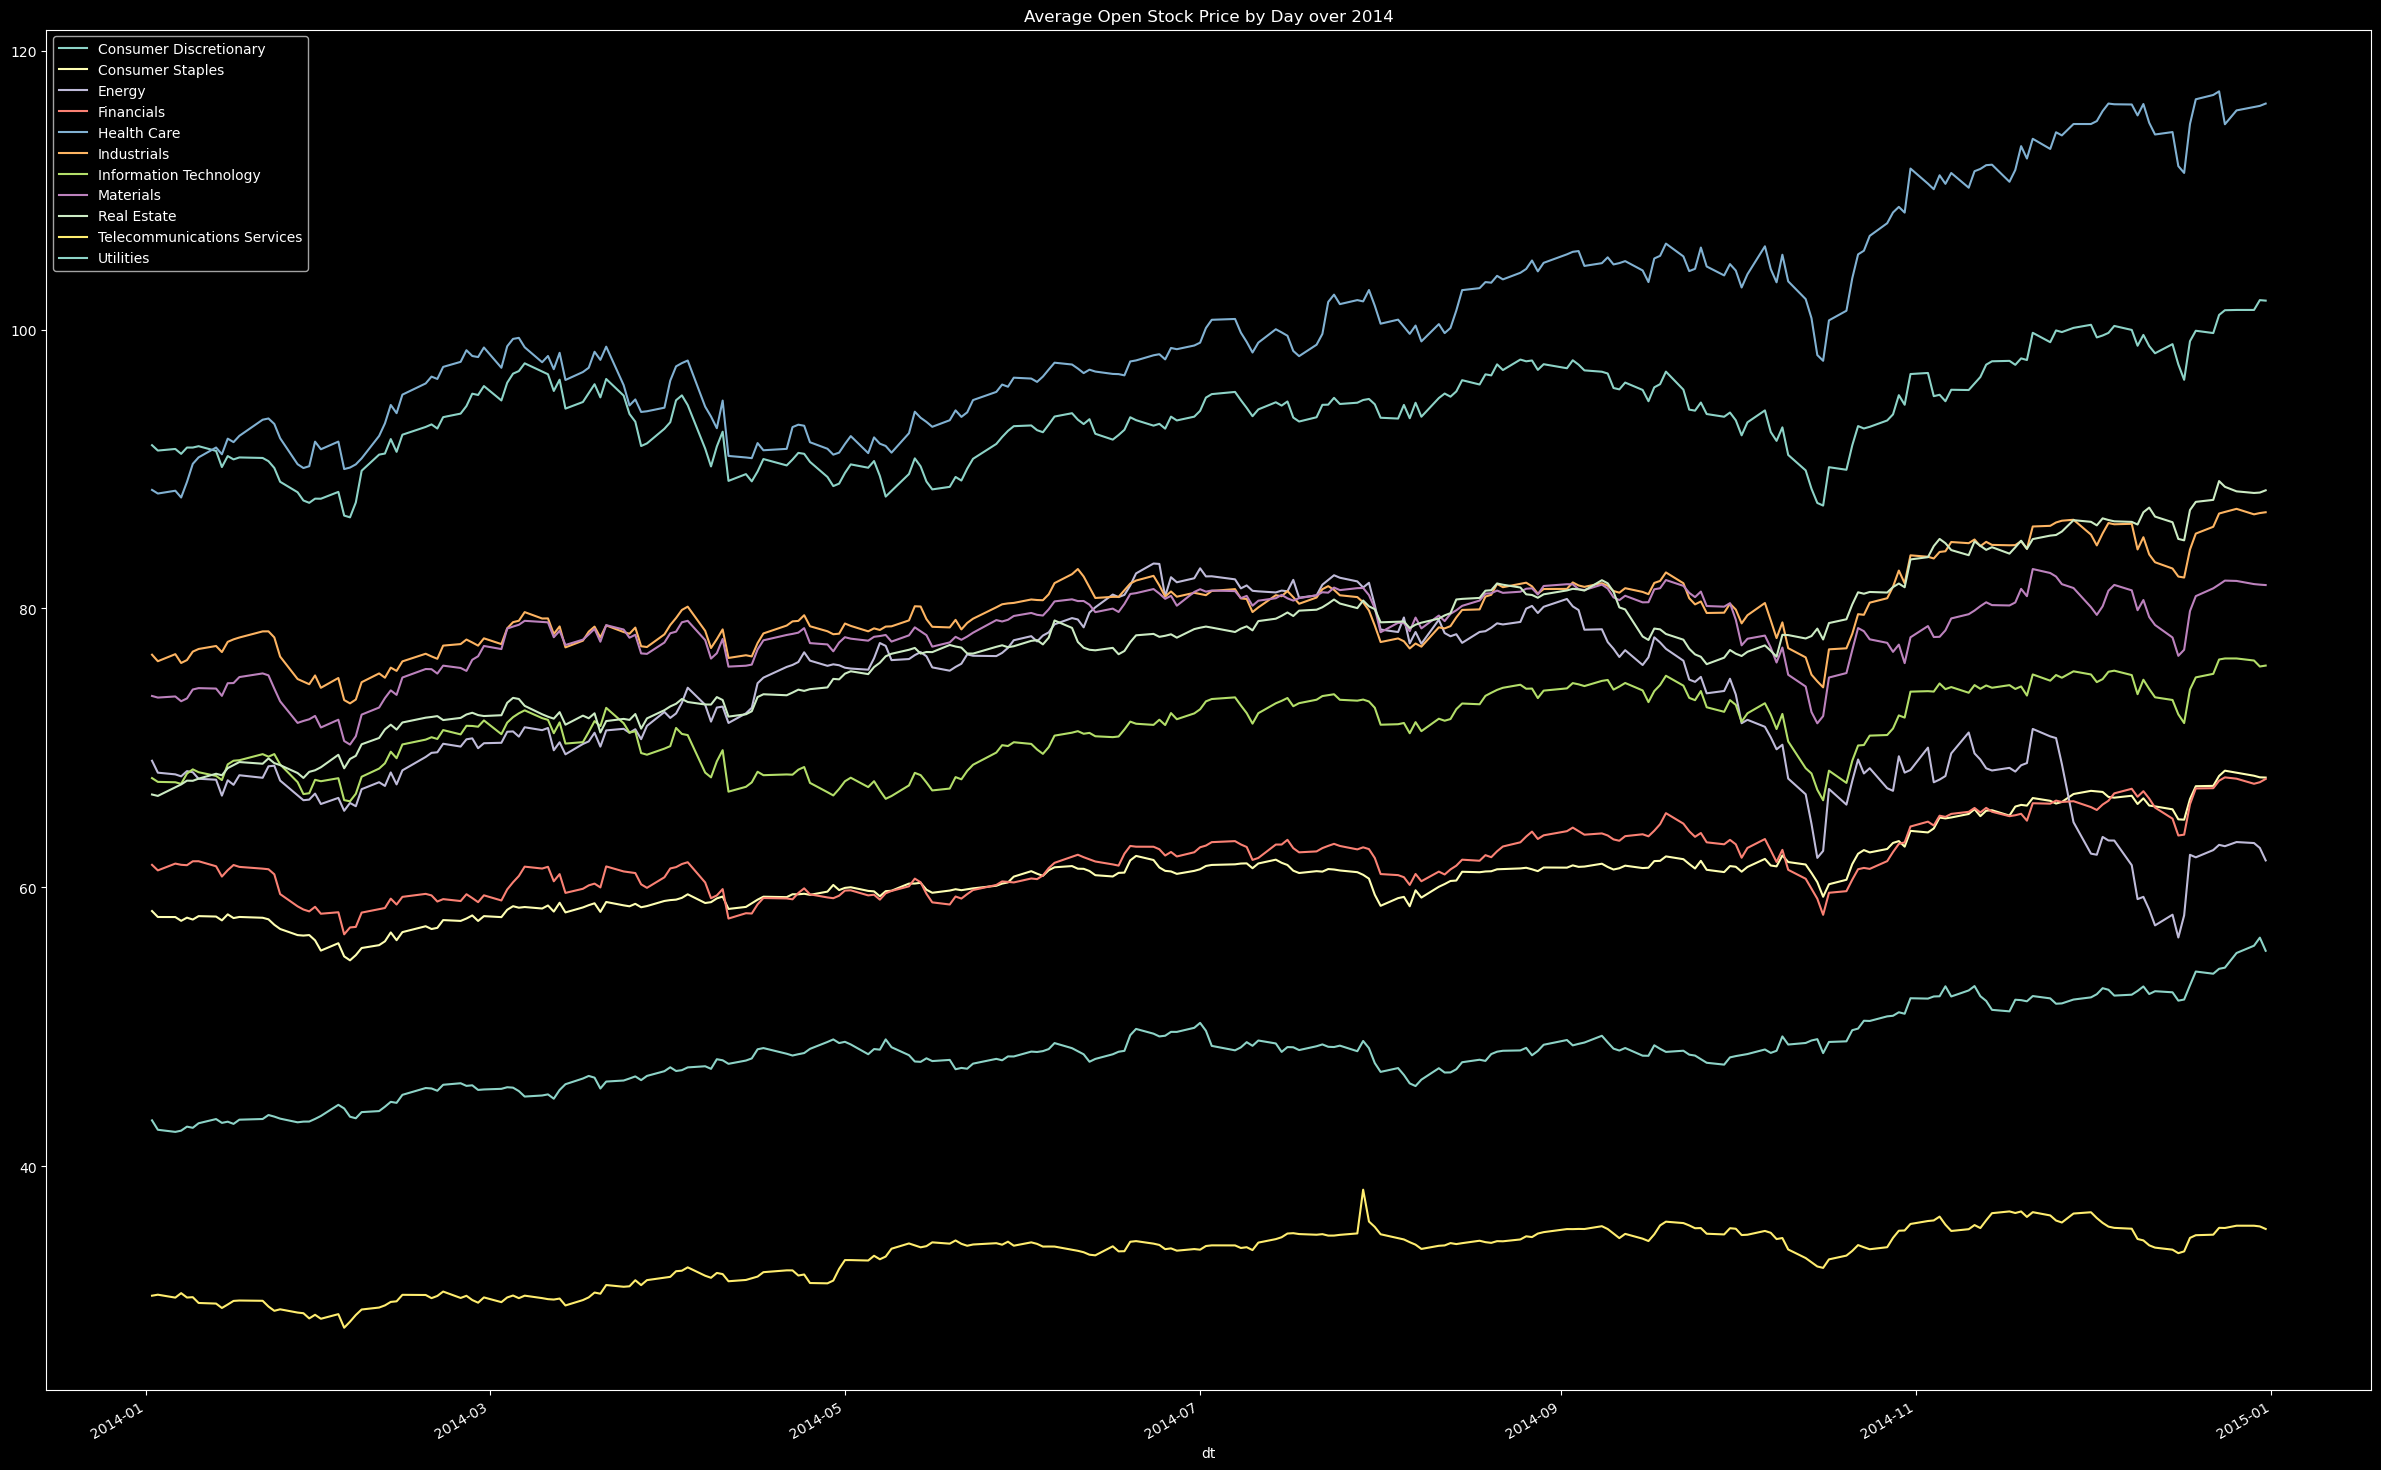

In [89]:
## In this cell we will plot the average stock open price for each day in 2014 by industry to get some insights on our response variable

## Data manipulation to get date, open price, and industry
eda_new = psa_df.join(ind_df, ['symbol'], how='inner')
eda_price = eda_new.groupBy("date","GICS Sector").mean("open")

## Data manipulation to get the time period
eda_price_plot = eda_price.withColumn('dt', to_timestamp(eda_price.date, 'yyyy-MM-dd'))
dates = ("2014-01-01",  "2014-12-31")
eda_price_plot = eda_price_plot.where(col('date').between(*dates))
eda_price_plot = eda_price_plot.withColumnRenamed('avg(open)', 'open')

## Creating the pivot table and converting to pandas
pivot_eda_price_plot = eda_price_plot.groupBy("dt") \
 .pivot("GICS Sector") \
 .agg(expr("coalesce(first(open))"))
panda_pivot_eda_plot = pivot_eda_price_plot.toPandas()

## Plotting the data
panda_pivot_eda_plot.plot(x="dt", y=["Consumer Discretionary","Consumer Staples","Energy","Financials","Health Care","Industrials","Information Technology","Materials","Real Estate","Telecommunications Services","Utilities"],
        kind="line",figsize=(30,20))
plt.title("Average Open Stock Price by Day over 2014")
plt.style.use("dark_background")
plt.show()

## Variable Reduction Technique

Our training dataset provides us with 70+ numerical variables, thus we will want to reduce the number of available features in some manner. A quick way to reduce the variables as shown in DS-5110 would be to compute the univariate area under the ROC curve (AUROC). This will allow us to quickly be able to see which variables have the a direct impact on classifying our response variable. We will fit a separate quick and dirty logistic regression model using one feature in each model and then calculating the AUROC. Following this, we will decide on an AUROC threshold in which to retain the numeric variables.

In [90]:
## In this cell we created a function similar to one we used in DS5110 to calculate the univariate aucs between each numeric variable
## and the response variable in our dataset. This will allow us to trim our dataset by seeing individually which variables are most predictive
## when not under the influence of the other variables. We will leverage this method from class to reduce our features.

def compute_univariate_aucs(df, target,training_fraction, max_iterations = 10, seed = 314):
    feats = df.columns[3:78] #### for our data set this are the columns we are intersted in removes unnecessary columns
    auroc = []
    weights = []
    var_name = []

    for variable in feats:
        assembler = VectorAssembler(inputCols = [variable],
                                   outputCol = "features",
                                   handleInvalid = "skip")
        transformed = assembler.transform(df)
        trim = transformed.select("label","features")
        train_test = [training_fraction, 1 - training_fraction]
        train_data, test_data = trim.randomSplit(train_test, seed = seed)
        lr = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter = max_iterations, fitIntercept = True)
        lr_fit =lr.fit(train_data)
        predictions = lr_fit.transform(test_data)
        evaluator = BinaryClassificationEvaluator()
        auroc.append(evaluator.evaluate(predictions))
        weights.append(lr_fit.coefficients[0])
        var_name.append(variable)

    return pd.DataFrame(list(zip(var_name,auroc,weights)), columns = ["Variable", "AUROC", "Weight"]).sort_values(by = "AUROC", ascending = False)

In [67]:
## This cell will utilize our function above to return a pandas dataframe containing the AUROCs of each univariate model

##### This cell takes a long time, just refer to the cols = [] cell to get outcome of the following 3 cells #####

############ Commented out the "research =" line because this takes upward of an hour to run #############

## Some needed column renaming
training_df = training_df.withColumnRenamed("Sales, General and Admin.", "sga")
training_df = training_df.withColumnRenamed("Misc. Stocks", "ms")
training_df = training_df.withColumnRenamed("Net Income-Cont. Operations", "nico")

## Calling our function and storing it as a pandas DF called research
# research = compute_univariate_aucs(df = training_df, target = "label", training_fraction = .6, max_iterations = 10, seed = 131203)

In [68]:
## Printing out the top 25 for a table in the paper

# research.head(25)

,Variable,AUROC,Weight
43,Non-Recurring Items,0.625042,-1.193668e-09
28,Liabilities,0.609423,6.856260e-12
20,Goodwill,0.608489,4.896798e-11
13,Deferred Liability Charges,0.607470,-3.701060e-11
51,Other Investing Activities,0.598132,-1.477484e-10
66,Total Current Assets,0.594737,-2.609071e-11
2,Add'l income/expense items,0.594312,-6.647816e-11
1,Accounts Receivable,0.590577,-2.041494e-10
47,Other Current Assets,0.583871,-6.303748e-11
67,Total Current Liabilities,0.577759,-3.053324e-11


In [69]:
## Getting a list of the variables with AUROC over .55 to use as our numeric variables

variables_auc_55plus = research[research["AUROC"]>= .55]
auc_gt_55 = list(variables_auc_55plus["Variable"].values)
print(auc_gt_55)

['Non-Recurring Items', 'Liabilities', 'Goodwill', 'Deferred Liability Charges', 'Other Investing Activities', 'Total Current Assets', "Add'l income/expense items", 'Accounts Receivable', 'Other Current Assets', 'Total Current Liabilities', 'Net Borrowings', 'Interest Expense', 'Depreciation', 'Operating Margin', 'Sale and Purchase of Stock', 'Equity Earnings/Loss Unconsolidated Subsidiary', 'Intangible Assets', 'Fixed Assets', 'Deferred Asset Charges']


In [91]:
## Saving a list of the columns so we do not have to run the research command again

cols = ['Non-Recurring Items', 'Liabilities', 'Goodwill', 'Deferred Liability Charges', 'Other Investing Activities', 'Total Current Assets', "Add'l income/expense items", 'Accounts Receivable', 'Other Current Assets', 'Total Current Liabilities', 'Net Borrowings', 'Interest Expense', 'Depreciation', 'Operating Margin', 'Sale and Purchase of Stock', 'Equity Earnings/Loss Unconsolidated Subsidiary', 'Intangible Assets', 'Fixed Assets', 'Deferred Asset Charges']

The columns listed above all have an AUROC of 55% or higher when fit in a univariate logistic regression model with our label as the response. We decided on a threshold of 55%, since it is marginally higher than 50/50 guessing (AUROC = 50%). Our highest univariate AUROC is for the Non-Recurring Items feature at approximately 62.5%. Following this variable reduction, we still retain 20 numeric variables going into the model building process. The sole categorical variable added to the features dataset will be the GICS Sector. The GICS Sector is labels for the diffferent industries our tickers fall under. Next, we will do some exploratory data analysis of our reduced dataset.

# FEATURE VARIABLE EDA


In [92]:
## This cell will produce a summary for each numeric variable in our data set

eda = training_df.select(cols)
eda.select(cols).describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Non-Recurring Items,423,1.6445128605200946E8,1.0817359403532982E9,-7.404E8,2.0058E10
Liabilities,423,4.8418768085106385E8,2.8837175937499924E9,-6.639E9,3.7103E10
Goodwill,423,3.861907997635934E9,7.678030390697382E9,0.0,6.9777E10
Deferred Liability Charges,423,1.6976951536643026E9,4.76045068704802E9,0.0,4.5469E10
Other Investing Activities,423,-2.052476926713948E8,2.974971741796916E9,-5.2009E10,1.0578E10
Total Current Assets,423,6.998151479905437E9,1.3595987905503649E10,0.0,1.31839E11
Add'l income/expense items,423,1.1832659338061465E8,8.975300501353017E8,-4.577E9,1.1613E10
Accounts Receivable,423,-1.0975179196217494E8,6.120529902133034E8,-6.452E9,3.118E9
Other Current Assets,423,7.086479669030733E8,1.642181139410677E9,0.0,1.8096E10


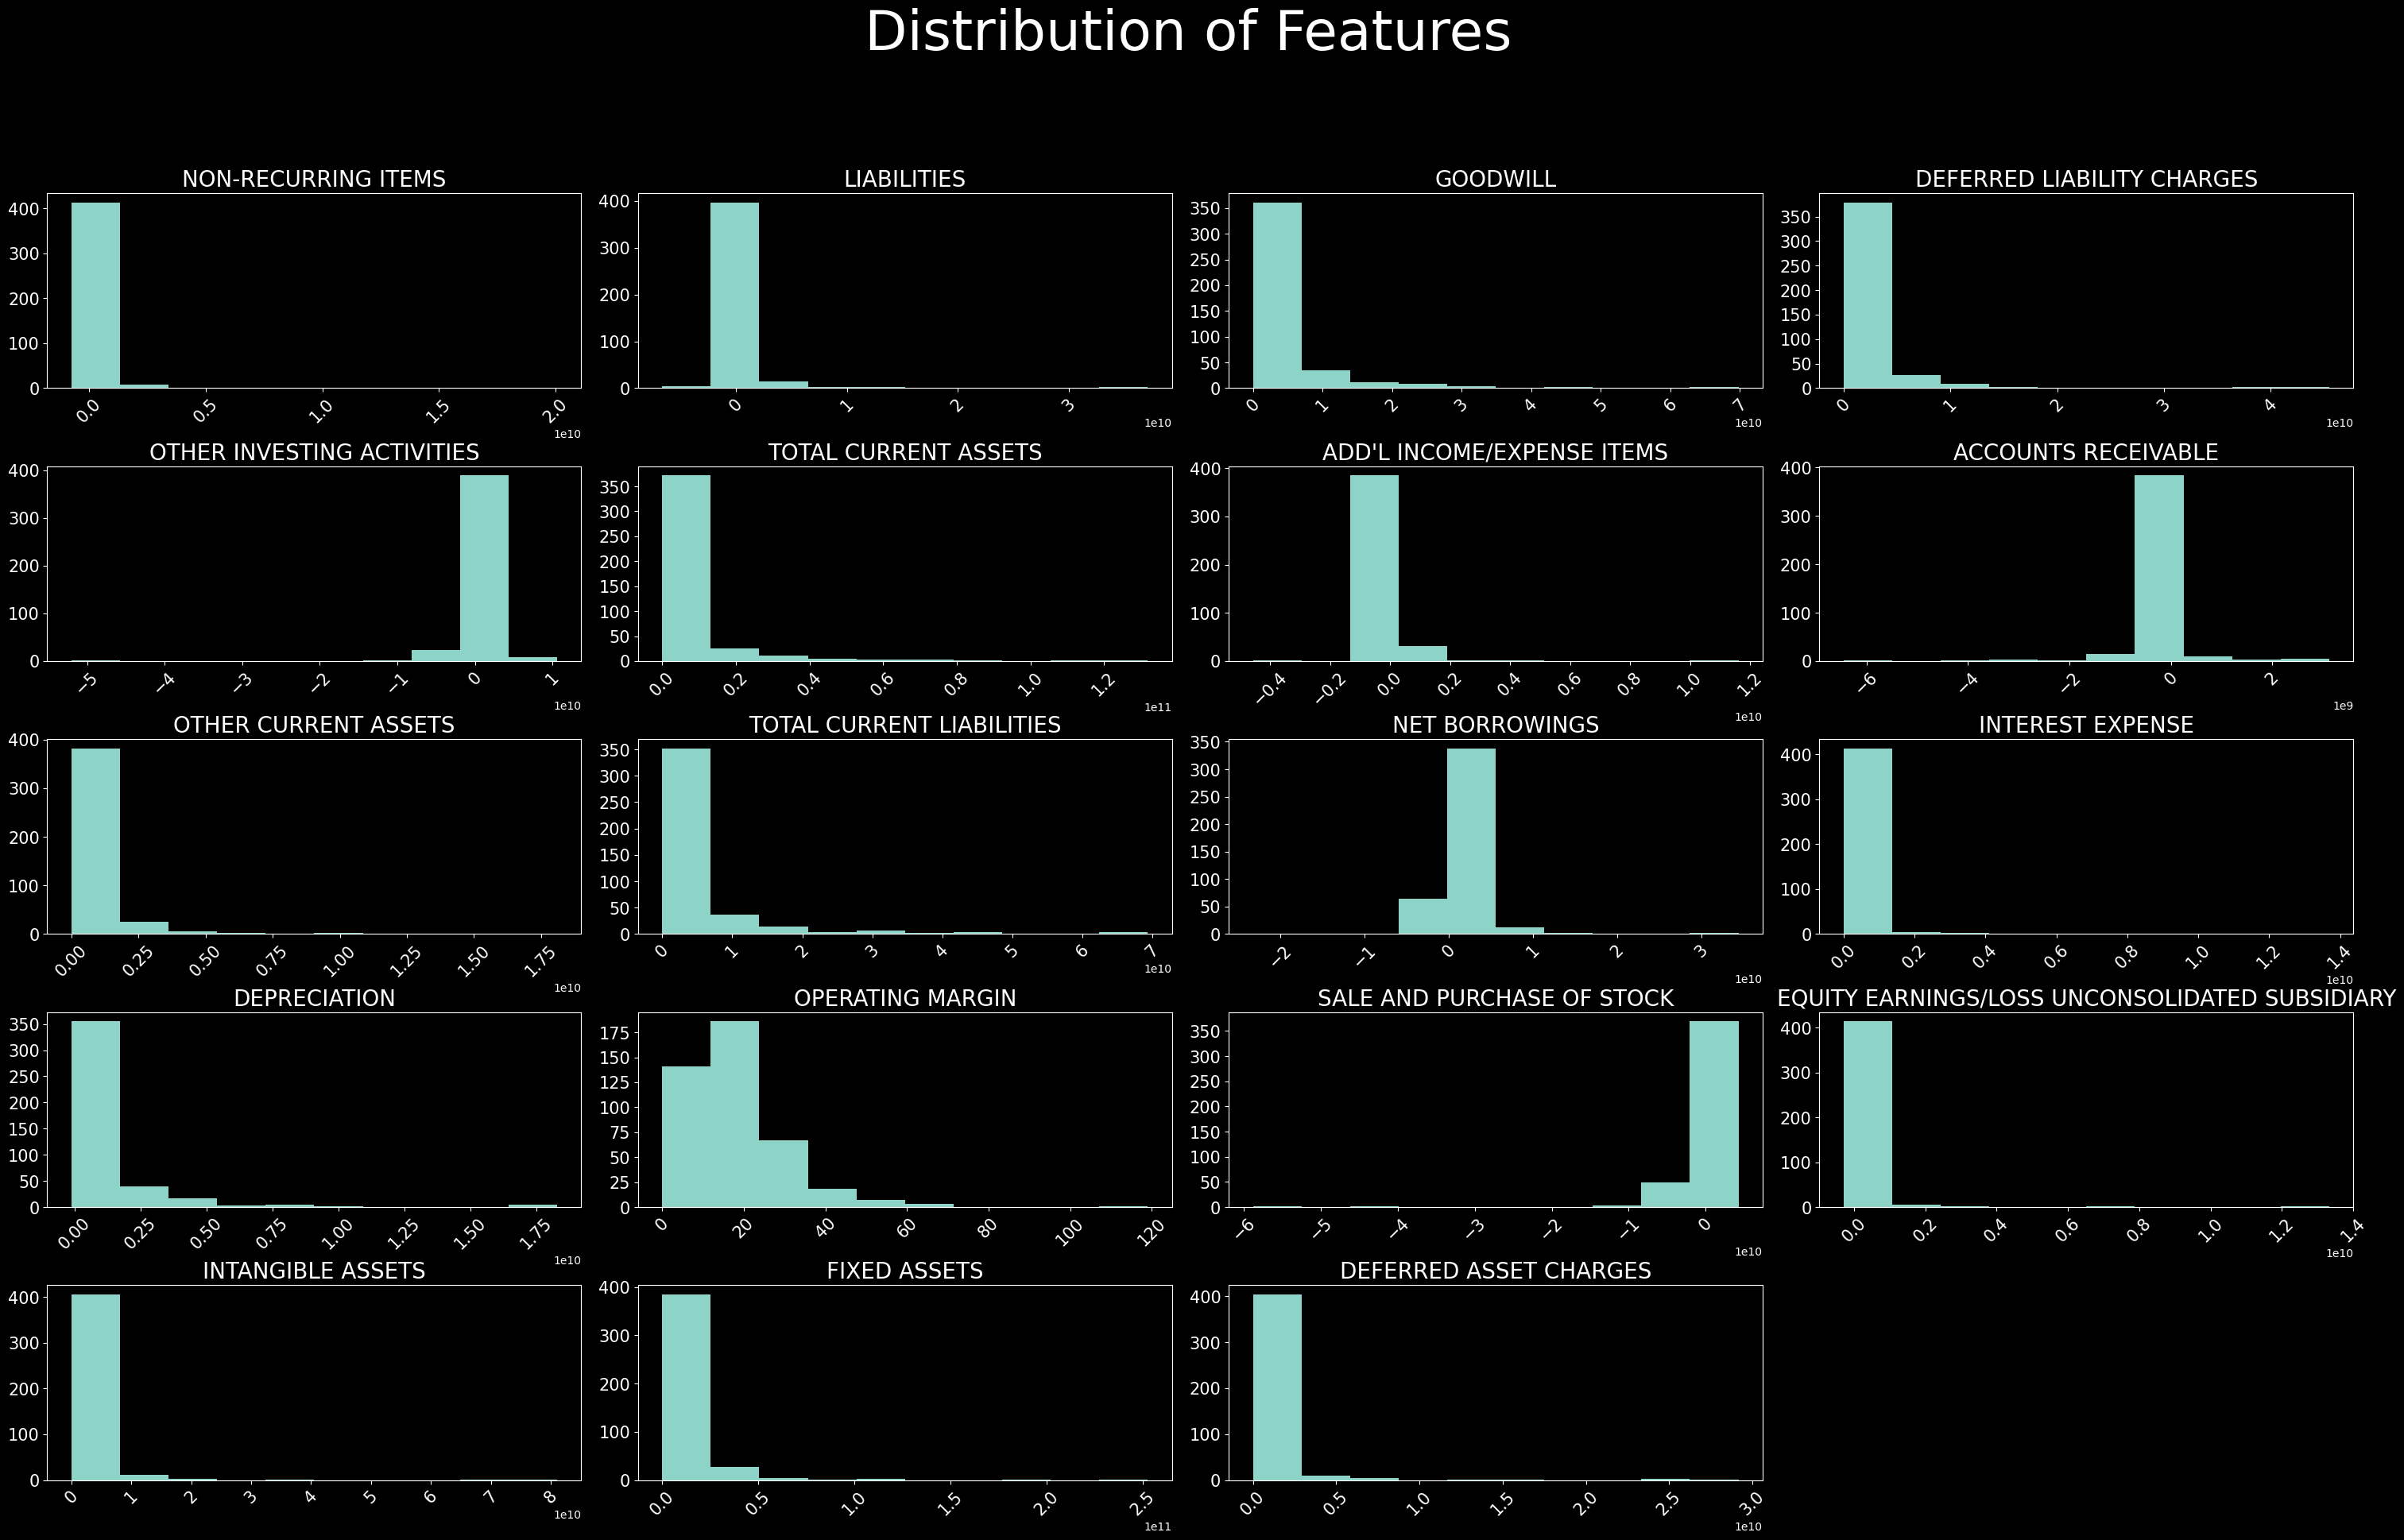

In [93]:
## This cell will create a histogram for every numeric variable in the datasets

fig = plt.figure(figsize=(30,20))
st = fig.suptitle("Distribution of Features", fontsize = 50,
                 verticalalignment = 'center')

for col,num in zip(eda.toPandas().describe().columns, range(1,20)):
    ax= fig.add_subplot(5,4,num)
    ax.hist(eda.toPandas()[col])
    plt.style.use("dark_background")
    plt.grid(False)
    plt.xticks(rotation = 45, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title(col.upper(),fontsize = 20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top = 0.85, hspace = 0.4)
plt.show()

###### As seen above there is a lot of skew in the distributions, so normalizing may help. Lets look at these variables, but separated by industry.

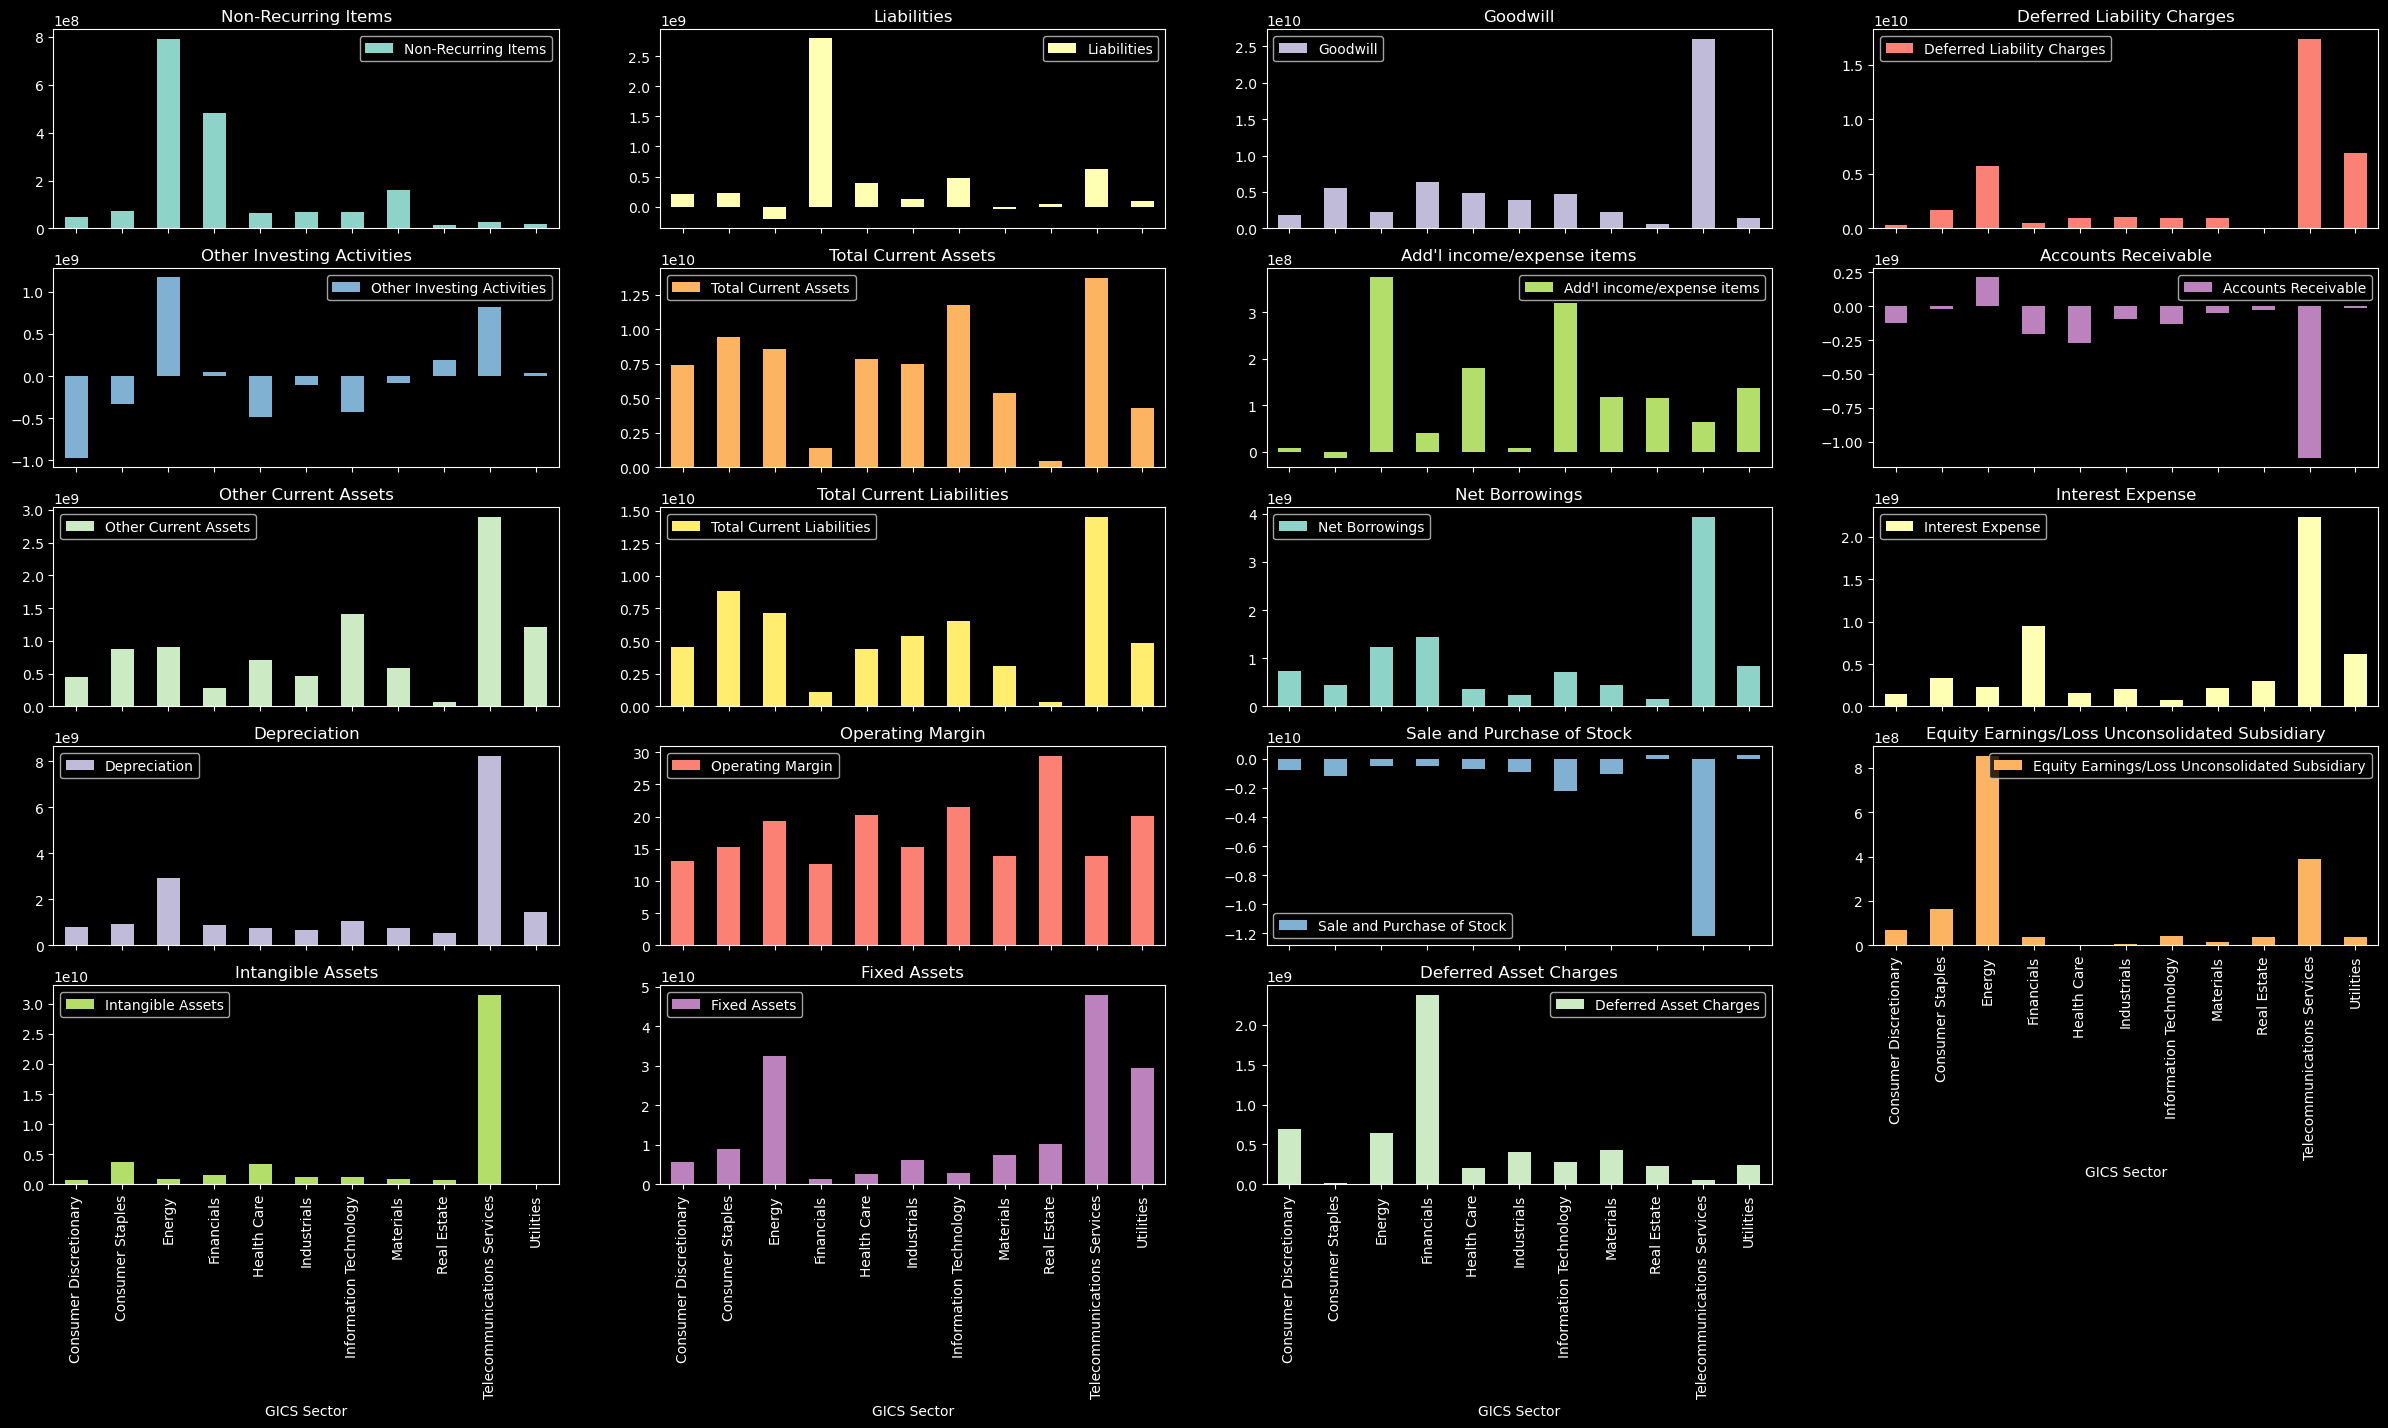

In [137]:
## This cell will be used to produce bar charts of mean values of our numeric variables by industry

## Data manipulation
eda_cols = cols+['GICS Sector']
eda_2 = training_df.select(eda_cols)
panda_eda_2 = eda_2.toPandas()

## Plotting the data
panda_eda_2.groupby('GICS Sector').mean().plot.bar(subplots=True, layout=(5,4), figsize=(30,15), sharex=True)
plt.title("Numeric Features by Industries")
plt.style.use("dark_background")
plt.show()

# MODEL CONSTRUCTION PART 1 QUICK AND DIRTY MODELS 60-40 SPLITS

### Data preparation pipeline

For this project we created a pipeline to prepare our dataset to be used accross many of the algorithms available in PySpark's MLlib. There were four main transformers we used within this pipeline beginning with the StringIndexer. We used the StringIndexer on our lone categorical variable "GICS Sector". We then read the output of our string indexer into the OneHotEncoder and our categorical variable was set for model development. Next, we needed to look at our subset of numerical variables. We utilized the VectorAssembler to create a vector of our features and the last method used in our pipeline was the Normalizer to create a vector of normalized variables as well. This pipeline will assist in quick data preparation for both our in time and out out time data samples.

In [95]:
## This cell will create a pipeline to prep all over our datasets for model development 

## Defining our categorical variables, initiating our stages, and one hot encoding the categoricals
categoricalColumns = ["GICS Sector"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'label', outputCol = 'label_final')
stages += [label_stringIdx]

## Defining our numeric columns and assembler our feature vectors, as well as our normalized feature vectores
numericCols = cols
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features", handleInvalid = "skip")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
stages += [assembler,normalizer]


## Creating our pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(training_df)

## Transforming our training dataframe and selected our wanted columns
training_df = pipelineModel.transform(training_df)
selectedCols = ['label_final', 'features', "features_norm"] + cols + ["GICS Sector"]
training_df = training_df.select(selectedCols)

## Adjusting our label names
training_df = training_df.withColumnRenamed("label_final", "label")
training_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- features_norm: vector (nullable = true)
 |-- Non-Recurring Items: double (nullable = true)
 |-- Liabilities: double (nullable = true)
 |-- Goodwill: double (nullable = true)
 |-- Deferred Liability Charges: double (nullable = true)
 |-- Other Investing Activities: double (nullable = true)
 |-- Total Current Assets: double (nullable = true)
 |-- Add'l income/expense items: double (nullable = true)
 |-- Accounts Receivable: double (nullable = true)
 |-- Other Current Assets: double (nullable = true)
 |-- Total Current Liabilities: double (nullable = true)
 |-- Net Borrowings: double (nullable = true)
 |-- Interest Expense: double (nullable = true)
 |-- Depreciation: double (nullable = true)
 |-- Operating Margin: double (nullable = true)
 |-- Sale and Purchase of Stock: double (nullable = true)
 |-- Equity Earnings/Loss Unconsolidated Subsidiary: double (nullable = true)
 |-- Intangible Assets: double

## In time data model development

In [96]:
## This cell creates a function that takes in the model object and the testing df and returns a confusion matrix
## As well as classification statistics as required in the instructions

def conf_matrix_and_model_stats(model, test_df):
    ## Get the predictions from the model and testing data set
    predictions = model.transform(test_df)
    
    ## Transform the dataframe to pandas which can easily be manipulated and plotted
    post_df = predictions.select("GICS Sector", 'label',  'prediction')
    pandas_df = post_df.toPandas()
    
    ## Get the confusion matrix and creates some lists and labels for the plots
    cf_matrix = confusion_matrix(pandas_df["label"].values, pandas_df["prediction"].values)
    group_names = ["True Neg" ,"False Pos","False Neg","True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    ## Plot the confusion matrix with the above labels
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title("CM for Model")
    ax.set_xlabel('\nPredicted Labels')
    ax.set_ylabel('Actual Labels')
    plt.show()

    ## Calculate all necessary model statistics
    evaluator = BinaryClassificationEvaluator()
    auc = evaluator.evaluate(predictions)
    TN = cf_matrix[0][0]
    FP = cf_matrix[0][1]
    FN = cf_matrix[1][0]
    TP = cf_matrix[1][1]
    Accuracy = (TP + TN)/ (TP+TN+FN+FP)
    Precision = TP / (TP + FP)
    Recall = TP/(TP + FN)
    F1 = (2* Precision * Recall) / (Precision + Recall)
    
    ## Concatenate all statistics into easy to use dataframe
    Model_Statistic = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
    Measures = [auc, Accuracy, Precision, Recall, F1]
    stats_dict = {"Statistic": Model_Statistic, "Measure": Measures}
    return pd.DataFrame(stats_dict).round(decimals = 4)

In [126]:
## This cell will fit a relatively basic logistic regression with a train test split of .6 and .4 and save the model as lrModel

train, test = training_df.randomSplit([0.6,0.4], seed = 42)
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

## Basic Logistic Regression 

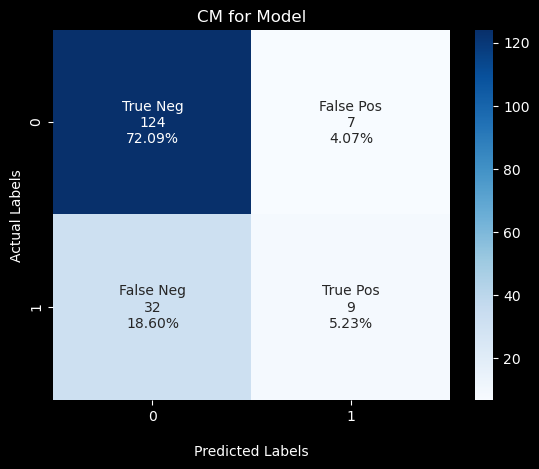

,Statistic,Measure
0,AUC,0.7187
1,Accuracy,0.7733
2,Precision,0.5625
3,Recall,0.2195
4,F1,0.3158


In [127]:
## This cell will get the predictions of the model fit above and calculate accuracy, precision, recall, F1 Score, a confusion matrix and auroc

conf_matrix_and_model_stats(model = lrModel, test_df = test)

## Logistic Regression with Normalized Features

In [128]:
## This cell will fit a relatively basic logistic regression with normalized numeric features with a train test split of .6 and .4 
## and save the model as lrModel_norm

train, test = training_df.randomSplit([0.6,0.4], seed = 42)
lr = LogisticRegression(featuresCol = 'features_norm', labelCol = 'label', maxIter=10)
lrModel_norm = lr.fit(train)

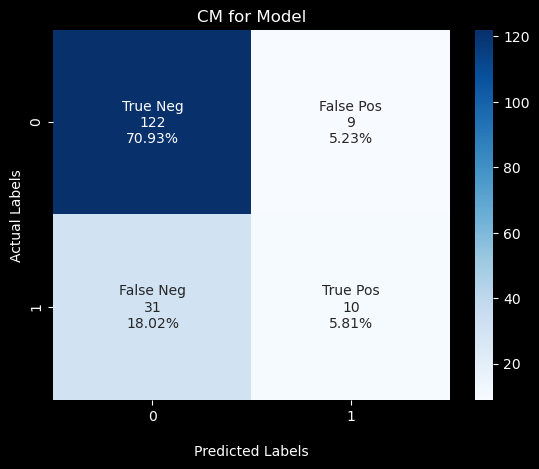

,Statistic,Measure
0,AUC,0.7170
1,Accuracy,0.7674
2,Precision,0.5263
3,Recall,0.2439
4,F1,0.3333


In [129]:
## This cell will get the predictions of the model fit above and calculate accuracy, precision, recall, F1 Score, a confusion matrix and auroc

conf_matrix_and_model_stats(model = lrModel_norm, test_df = test)

## Random Forest Model

In [101]:
## This cell will fit a random forest with the default parameters and save it as rfModel

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed = 42)
rfModel = rf.fit(train)

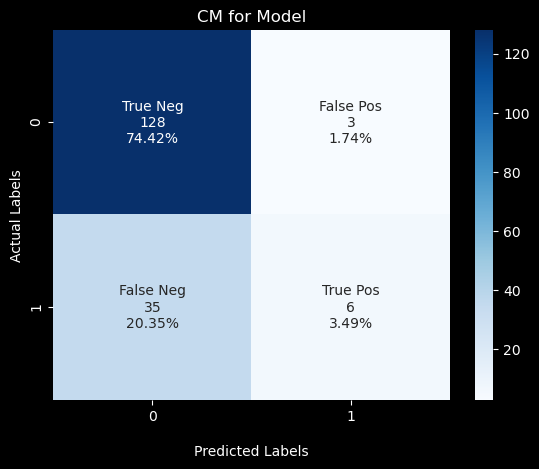

,Statistic,Measure
0,AUC,0.7276
1,Accuracy,0.7791
2,Precision,0.6667
3,Recall,0.1463
4,F1,0.2400


In [102]:
## This cell will get the predictions of the model fit above and calculate accuracy, precision, recall, F1 Score, a confusion matrix and auroc

conf_matrix_and_model_stats(model = rfModel, test_df = test)

## Random Forest Model with Normalized Features

In [103]:
## This cell will fit a random forest with normalized features with the default parameters and save it as rfModel_norm

rf = RandomForestClassifier(featuresCol = 'features_norm', labelCol = 'label', seed = 42)
rfModel_norm = rf.fit(train)

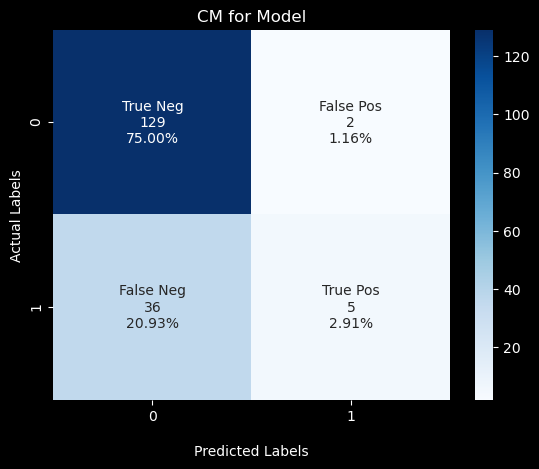

,Statistic,Measure
0,AUC,0.7213
1,Accuracy,0.7791
2,Precision,0.7143
3,Recall,0.1220
4,F1,0.2083


In [104]:
conf_matrix_and_model_stats(model = rfModel_norm, test_df = test)

## Gradient Boosted Trees Model

In [105]:
## This cell will fit a gradient boosted model with default features and saved it as gbt

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, seed = 42)
gbtModel = gbt.fit(train)

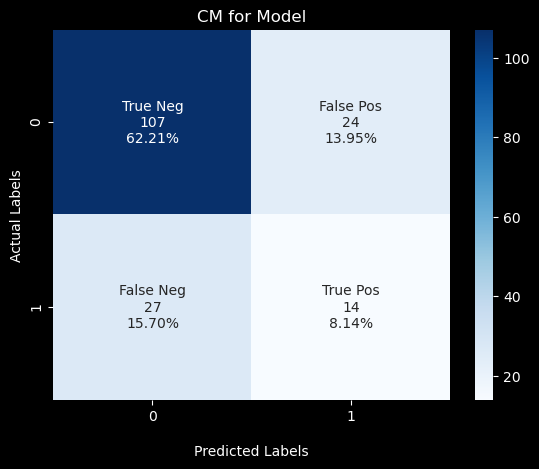

,Statistic,Measure
0,AUC,0.6414
1,Accuracy,0.7035
2,Precision,0.3684
3,Recall,0.3415
4,F1,0.3544


In [106]:
## This cell will get the predictions of the model fit above and calculate accuracy, precision, recall, F1 Score, a confusion matrix and auroc

conf_matrix_and_model_stats(model = gbtModel, test_df = test)

## Gradient Boosted Trees Model with Normalized Features

In [107]:
## This cell will fit a gradient boosted model with normalized features adn saved it as gbtModel_norm
gbt = GBTClassifier(labelCol="label", featuresCol="features_norm", maxIter=10, seed = 42)
gbtModel_norm = gbt.fit(train)

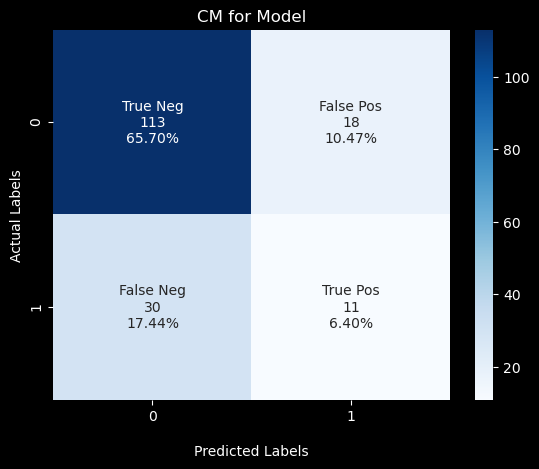

,Statistic,Measure
0,AUC,0.6745
1,Accuracy,0.7209
2,Precision,0.3793
3,Recall,0.2683
4,F1,0.3143


In [108]:
## This cell will get the predictions of the model fit above and calculate accuracy, precision, recall, F1 Score, a confusion matrix and auroc

conf_matrix_and_model_stats(model = gbtModel_norm, test_df = test)

# MODEL EVALUATION PART 1 ON QUICK AND DIRTY MODELS

## Normalized Random Forest Classifier performed the highest on testing AUC and precision so lets use that model on out of time data and see how it does

In [109]:
## This cell will utilize the pipeline made earlier to get the out of time testing set prepared

testing_df = pipelineModel.transform(testing_df)
selectedCols = ['label_final', 'features', "features_norm"] + cols + ["GICS Sector"]
testing_df = testing_df.select(selectedCols)
testing_df = testing_df.withColumnRenamed("label_final", "label")
testing_df.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|  200|
|  1.0|  217|
+-----+-----+



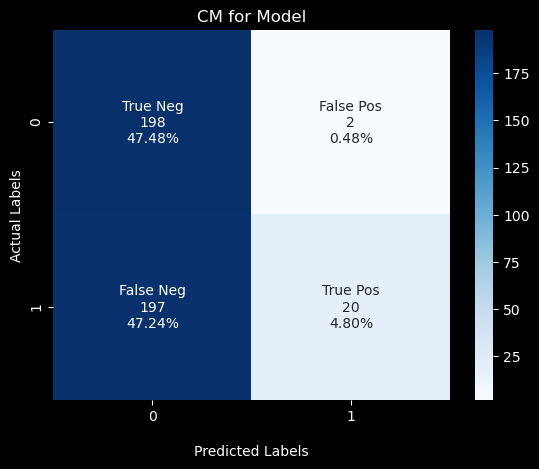

,Statistic,Measure
0,AUC,0.6577
1,Accuracy,0.5228
2,Precision,0.9091
3,Recall,0.0922
4,F1,0.1674


In [110]:
## This cell will get the out of time predictions based on our random forest normalized model fit earlier

conf_matrix_and_model_stats(model = rfModel_norm, test_df = testing_df)

#### Lets take a look at the non normalized randomforest model as well to decide which to crossvalidate and hyperparameter tune.

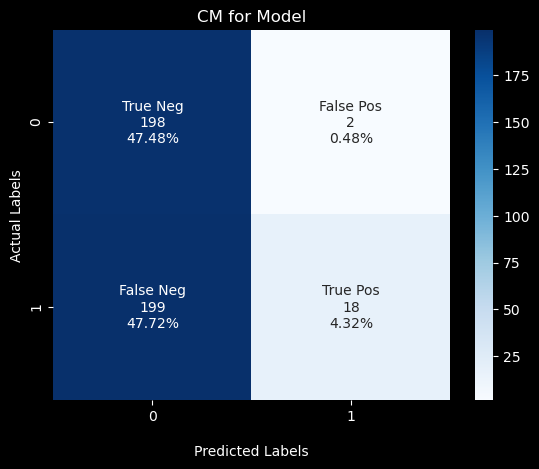

,Statistic,Measure
0,AUC,0.6561
1,Accuracy,0.5180
2,Precision,0.9000
3,Recall,0.0829
4,F1,0.1519


In [111]:
## This cell will get the out of time predictions based on our non normalized random forest model fit earlier

conf_matrix_and_model_stats(model = rfModel, test_df = testing_df)

# MODEL CONSTRUCTION PART 2 Cross Validation and Grid Search

In [131]:
## In this cell we will use the CrossValidator and paraGrid techniques to try to hone in our random forest model


evaluator = BinaryClassificationEvaluator()

rf = RandomForestClassifier(featuresCol = 'features_norm', labelCol = 'label', seed = 42)

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2,4,6])
             .addGrid(rf.maxBins, [20, 40, 60])
             .addGrid(rf.numTrees, [20, 40, 60])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(training_df)

Exception ignored in: <function JavaWrapper.__del__ at 0x7fb0142a4830>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


# MODEL EVALUATION PART 2 CV MODEL (FINAL MODEL)

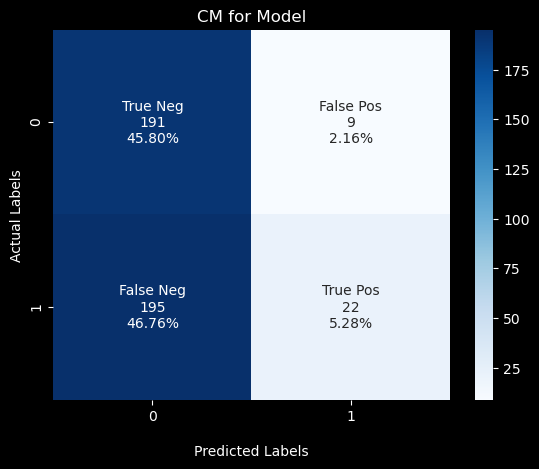

,Statistic,Measure
0,AUC,0.6220
1,Accuracy,0.5108
2,Precision,0.7097
3,Recall,0.1014
4,F1,0.1774


In [133]:
## In this cell we will get the confusion matrix and model stats on the out of time testing data on the CV model

conf_matrix_and_model_stats(model = cvModel, test_df = testing_df)

In [134]:
## In this cell we will look at if any industry had a high amount of the predicted events being 1

preds = cvModel.transform(testing_df)
industry_preds = preds.select("GICS Sector", "label", "prediction").filter(col("prediction") == 1.0)
industry_preds.groupby("GICS Sector").count().show()

+--------------------+-----+
|         GICS Sector|count|
+--------------------+-----+
|              Energy|   24|
|Information Techn...|    1|
|           Materials|    1|
|          Financials|    5|
+--------------------+-----+



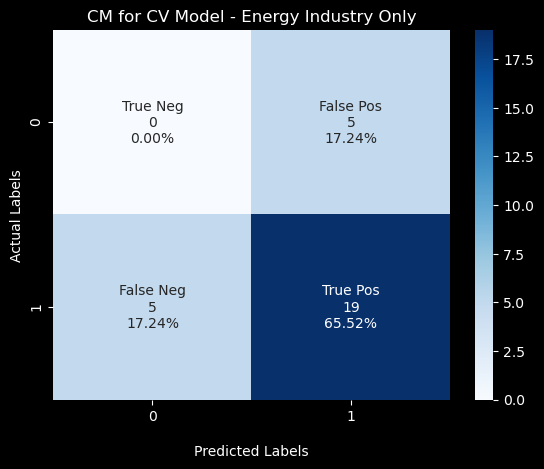

,Statistic,Measure
0,AUC,0.4167
1,Accuracy,0.6552
2,Precision,0.7917
3,Recall,0.7917
4,F1,0.7917


In [135]:
## In this cell we will take the predictions for the Energy industry alone and plot the confusion matrix

## Get the predictions from the model and testing data set
predictions = preds.select("GICS Sector", "label", "prediction", "rawPrediction").filter(col("GICS Sector") == "Energy")

## Transform the dataframe to pandas which can easily be manipulated and plotted
post_df = predictions.select("GICS Sector", 'label',  'prediction', 'rawPrediction')
pandas_df = post_df.toPandas()
    
## Get the confusion matrix and creates some lists and labels for the plots
cf_matrix = confusion_matrix(pandas_df["label"].values, pandas_df["prediction"].values)
group_names = ["True Neg" ,"False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
    
## Plot the confusion matrix with the above labels
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title("CM for CV Model - Energy Industry Only")
ax.set_xlabel('\nPredicted Labels')
ax.set_ylabel('Actual Labels')
plt.show()

## Calculate all necessary model statistics
evaluator = BinaryClassificationEvaluator()
auc = evaluator.evaluate(predictions)
TN = cf_matrix[0][0]
FP = cf_matrix[0][1]
FN = cf_matrix[1][0]
TP = cf_matrix[1][1]
Accuracy = (TP + TN)/ (TP+TN+FN+FP)
Precision = TP / (TP + FP)
Recall = TP/(TP + FN)
F1 = (2* Precision * Recall) / (Precision + Recall)
    
## Concatenate all statistics into easy to use dataframe
Model_Statistic = ["AUC", "Accuracy", "Precision", "Recall", "F1"]
Measures = [auc, Accuracy, Precision, Recall, F1]
stats_dict = {"Statistic": Model_Statistic, "Measure": Measures}
pd.DataFrame(stats_dict).round(decimals = 4)